In [1]:
"""James Gardner 2019"""
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

In [2]:
catalogue = pd.read_csv('patch_catalogue.csv')
catalogue.set_index(['name_TGSS','name_NVSS'], inplace=True)
# catalogue = catalogue.set_index(['name_TGSS','name_NVSS'],inplace=True)

cat_matches = set(catalogue.index.values)

In [3]:
tgss_df = pd.read_csv('tgss.csv')
tgss_df.set_index('name_TGSS', inplace=True)

nvss_df = pd.read_csv('nvss.csv')
nvss_df.set_index('name_NVSS', inplace=True)

In [4]:
def naivest_scorer(name_TGSS,name_NVSS):
    """given two names, tells if in catalogue"""  
    if (name_TGSS,name_NVSS) in catalogue.index:
        return 1
    else:
        return 0

In [5]:
def separation_scorer(name_TGSS,name_NVSS):
    """given two names, gives separation
    by set-up, only gives non-zero for those in catalogue"""
    if (name_TGSS,name_NVSS) in catalogue.index:
        sep = catalogue.loc[name_TGSS,name_NVSS].separation
        sep *= 3600
        return max(0,(40-sep)/40)
    else:
        return 0

In [6]:
def spectral_scorer(name_TGSS,name_NVSS):
    """given two names, not necessarially in catalogue
    returns score using hist_alpha dist as pdf
    takes two arbitrary names, looks them up in respective
    catalogues, and runs the scorer on them"""

    alpha = catalogue['spectral_alpha'].values
    num_alpha_bins = 100
    pdf_alpha = np.histogram(alpha,bins=num_alpha_bins,density=True)
    a0,a1 = np.min(alpha),np.max(alpha)    
    
    obj_t = tgss_df.loc[name_TGSS]
    obj_n = nvss_df.loc[name_NVSS]
    
    FREQ_TGSS,FREQ_NVSS = 150e6,1.4e9
    my_alpha = np.log(obj_t['peak_TGSS']/obj_n['peak_NVSS']
                     )/np.log(FREQ_NVSS/FREQ_TGSS)

    if my_alpha < a0 or a1 < my_alpha:
        return 0
    else:
        #re-normalise
        pval = pdf_alpha[0][min(np.searchsorted(pdf_alpha[1],my_alpha),
                                len(pdf_alpha[0])-1)]
        pval = pval/(a1-a0)
        return pval

In [7]:
def combo_scorer(name_TGSS,name_NVSS):
    """weighted score from sep and alpha pdf
    non-naive scorer uses separation and spectral index
    """
    s1 = separation_scorer(name_TGSS,name_NVSS)
    s2 = spectral_scorer(name_TGSS,name_NVSS)
    # change w1 to rebalance
    w1 = 0.8
    w2 = 1-w1
    return w1*s1+w2*s2

In [8]:
def score_the_cat(catalogue,scorer,hist_name=None):
    """evaluates the scorer on each match in the catalogue,
    saves a histogram of the scores
    """
    stc = np.array([scorer(name_TGSS,name_NVSS) for 
                    (name_TGSS,name_NVSS) in tqdm(cat_matches)])
    stc = stc[stc!=0]
    
    # normalise, top score is now 1
    top = np.max(stc)
    stc = stc*1/top    
    
    if hist_name is None:
        hist_name = 'hist_patch_cat_score'
        
    # display histogram of scores
    plt.figure(figsize=(14,7))
    plt.rcParams.update({'font.size': 18})
    plt.hist(stc, bins=100)#,color = "darkmagenta", ec="orchid")
    plt.xlim(-0.01,1.01)
    plt.xlabel("match score")
    plt.ylabel('counts')
    plt.title('distribution of scores of catalogue matches in patch')
    plt.savefig('{}.png'.format(hist_name),bbox_inches='tight')    

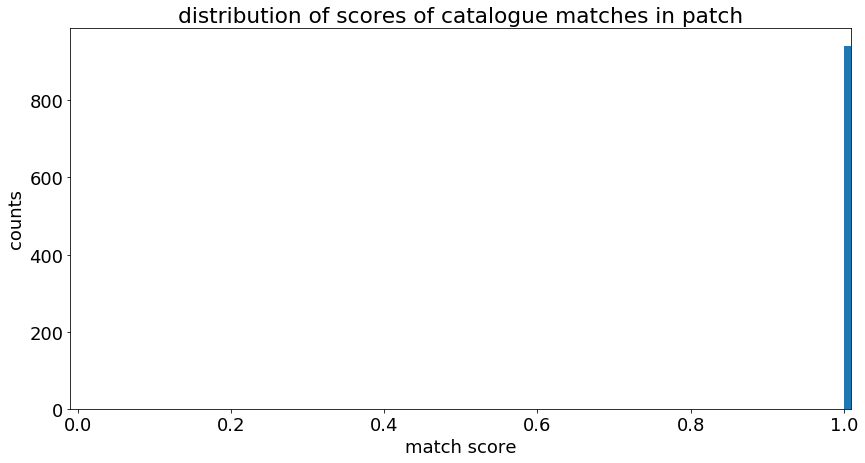

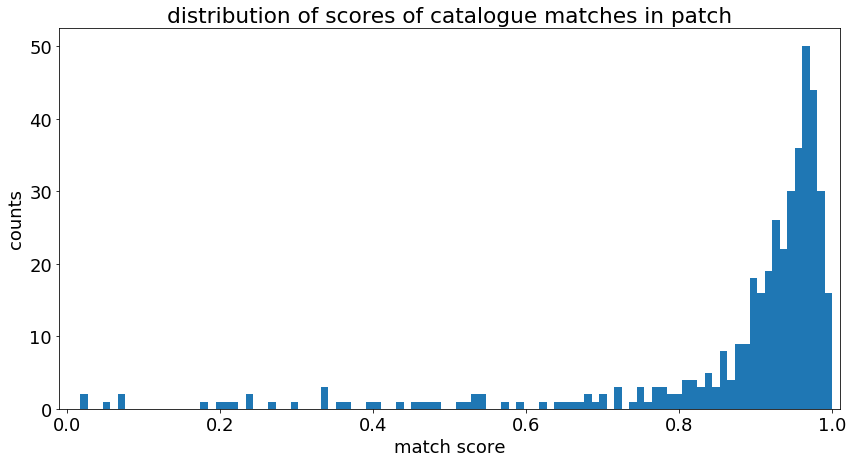

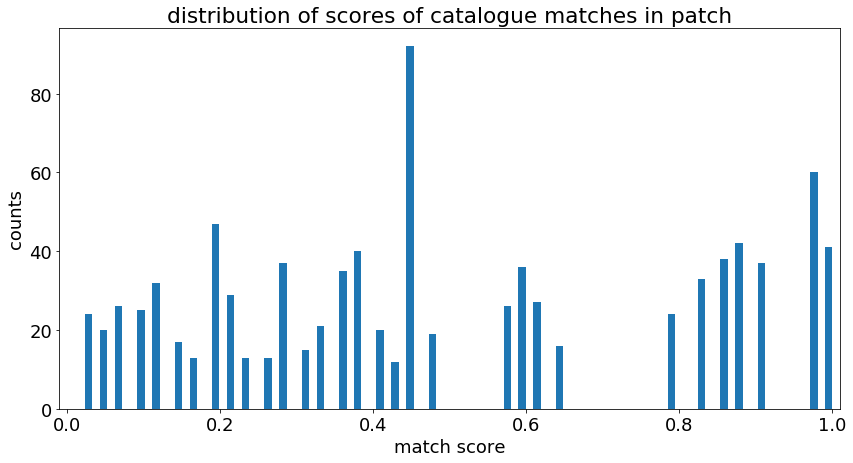

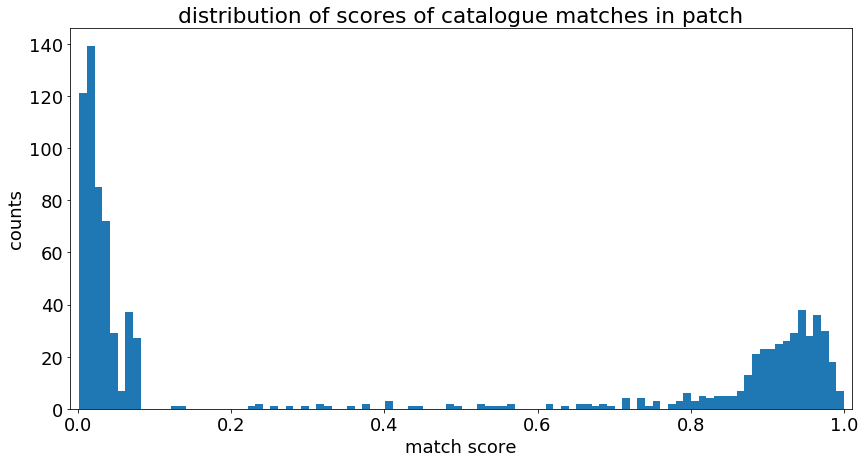

In [9]:
hist_names = {'hist_patch_cat_score_naive':naivest_scorer,
              'hist_patch_cat_score_separation':separation_scorer,
              'hist_patch_cat_score_spectral':spectral_scorer,
              'hist_patch_cat_score_combo':combo_scorer}

for key in hist_names:
    score_the_cat(catalogue,hist_names[key],key)

In [10]:
def looper_TGSS_scorer(name_TGSS,scorer):
    best_match = (0,'')
    for name_NVSS in nvss_df.index.values:
        score = scorer(name_TGSS,name_NVSS)
        if best_match[0] < score:
            best_match = (score,name_NVSS)
    return best_match

def looper_NVSS_scorer(name_NVSS,scorer):
    best_match = (0,'')
    for name_TGSS in tgss_df.index.values:
        score = scorer(name_TGSS,name_NVSS)
        if best_match[0] < score:
            best_match = (score,name_TGSS)
    return best_match

In [16]:
# sort the sky
tgss_df.reset_index(inplace=True)
best_match = np.array([looper_TGSS_scorer(name_TGSS,separation_scorer)
                       for name_TGSS in tqdm(tgss_df['name_TGSS'])])
tgss_df['score'] = best_match[:,0]
tgss_df['best_match'] = best_match[:,1]
tgss_df.set_index('name_TGSS',inplace=True)
tgss_df.sort_values(by=['score'],inplace=True)

nvss_df.reset_index(inplace=True)
best_match = np.array([looper_NVSS_scorer(name_NVSS,separation_scorer)
                       for name_NVSS in tqdm(nvss_df['name_NVSS'])])
nvss_df['score'] = best_match[:,0]
nvss_df['best_match'] = best_match[:,1]
nvss_df.set_index('name_NVSS',inplace=True)
nvss_df.sort_values(by=['score'],inplace=True)

scores = [separation_scorer(name_TGSS,name_NVSS)
          for (name_TGSS,name_NVSS) in tqdm(cat_matches)]
catalogue['score'] = scores
catalogue.sort_values(by=['score'],inplace=True)

In [12]:
def old_naivest_scorer(tobj,nobj):
    """given two names, tells if in catalogue"""
    if np.any(np.equal(names,[tobj,nobj]).all(1)):
        return 1
    else:
        return 0

def old_naive_scorer(tobj,nobj):
    """given two names, if unique match in catalogue, then gives separation"""
    
    # COMMENT BACK IN TO SLOW DOWN
    #if not np.any(np.equal(names,[tobj,nobj]).all(1)):
    #    return 0

    c_index = int(np.where(np.all(names==[tobj,nobj],axis=1))[0])    
    # look up pandas lookup
    
    #UNIQUENESS FLAG
    if catalogue[c_index][7] == 1:
        return 0
    
    sep = catalogue[c_index][6]*3600
    return max(40-sep,0)/40

# alpha = catalogue[:,10]
# # hist_alpha = np.histogram(alpha,bins=200,density=False)
# pdf_alpha = np.histogram(alpha,bins=200,density=True)
# # print(pdf_alpha)
# a0,a1 = np.min(alpha),np.max(alpha)

def old_spectral_scorer(tobj,nobj):
    """given two names, if unique match in catalogue,
    returns score using hist_alpha dist as pdf"""
    
    c_index = int(np.where(np.all(names==[tobj,nobj],axis=1))[0])    

    if catalogue[c_index][7] == 1:
        return 0    
    
    my_alpha = catalogue[c_index][10]
    if my_alpha < a0 or a1 < my_alpha:
        return 0
    
    # histogram(density=True) gives pdf not prob mass function, need to renormalise
    pval = pdf_alpha[0][np.searchsorted(pdf_alpha[1],my_alpha)]
    pval = pval/(a1-a0)
    return pval

def old_combo_scorer(tobj,nobj):
    """even split, sep and alpha pdf
    non-naive scorer could use separation, non-uniqueness flag, spectral index
    """
    s1 = naive_scorer(tobj,nobj)
    s2 = spectral_scorer(tobj,nobj)
    # change w1 to rebalance
    w1 = 0.2
    w2 = 1-w1
    return w1*s1+w2*s2

def old_score_the_cat(catalogue,scorer,hist_name=None):
    """evaluates the scorer on each match in the catalogue,
    saves a histogram of the scores"""
    cat_names = catalogue[:,(0,3)]
    if hist_name is None:
        hist_name = 'hist_cat_score'
    
    stc = np.zeros(len(cat_names))
    for i,n in enumerate(tqdm(cat_names)):
        stc[i] = scorer(n[0],n[1])
    #return stc
    
    # drop all zero scores
    stc = stc[stc!=0]
        
    # normalise, top score is now 1
    #top = np.max(stc)c
    #stc = stc*1/top    
        
    # display histogram of scores
    plt.figure(figsize=(14,7))
    plt.rcParams.update({'font.size': 18})
    plt.hist(stc, bins=100)#,color = "darkmagenta", ec="orchid")
    plt.xlim(-0.01,1.01)
    plt.xlabel("match score")
    plt.ylabel('counts')
    plt.title('distribution of scores of catalogue matches')
    plt.savefig('{}.png'.format(hist_name),bbox_inches='tight')
    
# old_score_the_cat(catalogue[:1000],naivest_scorer,'hist_cat_score_naivest')
# old_score_the_cat(catalogue[:10000],naive_scorer,'hist_cat_score_naive')
# old_score_the_cat(catalogue[:1000],spectral_scorer,'hist_cat_score_spectral')
# old_score_the_cat(catalogue[:1000],combo_scorer,'hist_cat_score_combo')    

In [13]:
# """
# p_dec = -35
# p_ra  = 149
# patch_size = 5
# sep_lim = 5*1/60
# patch_dec = (p_dec < catalogue['dec_TGSS']) & (catalogue['dec_TGSS'] < p_dec+patch_size)
# patch_ra =  (p_ra  < catalogue['ra_TGSS'])  & (catalogue['ra_TGSS']  < p_ra+patch_size)
# cat_in_box = catalogue[patch_dec & patch_ra]#.describe().dropna()
# cat_in_box = cat_in_box[cat_in_box['separation'] < sep_lim]
# """

In [14]:
# catalogue = pd.read_csv('catalogue.csv', names = 
#                        ['name_TGSS','ra_TGSS','dec_TGSS','name_NVSS','ra_NVSS','dec_NVSS',
#                         'separation','is_non-unique','S_TGSS','S_NVSS','spectral_alpha'])
# catalogue.set_index(['name_TGSS','name_NVSS'],inplace=True)